<a href="https://colab.research.google.com/github/DiGyt/snippets/blob/master/deepest_dive_into_music.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import io
import base64
import numpy as np
import scipy.io.wavfile as wavfile
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt
from IPython.display import HTML

In [53]:
def euclidean_loop_audio(k=5, n=16, bpm=120, bars=4, sr=44100):
    import numpy as np

    # Correct Bjorklund / Euclidean rhythm
    def euclidean_rhythm(k, n):
        if k == 0: return [0]*n
        if k == n: return [1]*n

        groups = [[1] for _ in range(k)] + [[0] for _ in range(n - k)]

        while True:
            l = len(groups)
            if l <= 1: break

            # find how many pairs to merge
            count = min(len([g for g in groups if g == [1]]), len([g for g in groups if g == [0]]))
            if count == 0: break

            new_groups = []
            for i in range(count):
                new_groups.append(groups[i] + groups[-(i+1)])
            # keep the middle untouched if odd
            if 2*count < l:
                new_groups += groups[count:-count]
            groups = new_groups

        return [x for g in groups for x in g]

    # Generate Euclidean pattern
    pattern = euclidean_rhythm(k, n)

    # Step duration in samples
    step_time = 60 / bpm / 4
    step_samples = int(step_time * sr)

    # Generate single pulse
    def pulse(sr=44100, duration=0.01, freq=100):
        t = np.linspace(0, duration, int(sr*duration), False)
        p = np.sin(2*np.pi*freq*t) * np.exp(-60*t)
        return t, p

    t, click = pulse(sr)

    # Make sure pulse fits in step
    if len(click) > step_samples:
        click = click[:step_samples]

    # Fill the bar with pulses
    bar = np.zeros(step_samples * n)
    for i, step in enumerate(pattern):
        if step:
            bar[i*step_samples:i*step_samples+len(click)] += click

    # Tile for bars
    audio = np.tile(bar, bars)
    audio /= np.max(np.abs(audio))
    return audio


def play_with_waveform_interface(audios, sr=44100, width=400, height=50):
    from IPython.display import HTML
    import io, base64
    import scipy.io.wavfile as wavfile

    if not isinstance(audios, list):
        audios = [audios]

    wav_datas = []
    precomputed = []

    for audio in audios:
        # normalize
        #audio = audio / max(1e-12, np.max(np.abs(audio)))
        buf = io.BytesIO()
        wavfile.write(buf, sr, (audio*32767).astype(np.int16))
        b64 = base64.b64encode(buf.getvalue()).decode()
        wav_datas.append(b64)

        # precompute waveform and pattern once
        step = max(1, len(audio)//width)
        samples = [float(np.max(np.abs(audio[i:i+step]))) for i in range(0, len(audio), step)]
        pattern = [1 if s>0.001 else 0 for s in samples]
        precomputed.append((samples, pattern))

    html_tracks = ""
    for idx, (b64, (samples, pattern)) in enumerate(zip(wav_datas, precomputed)):
        html_tracks += f"""
<div style="display:flex; align-items:center; margin-bottom:20px;">
  <canvas id="wave{idx}" width="{width}" height="{height}" style="border:1px solid #ccc;"></canvas>
  <canvas id="circle{idx}" width="{height}" height="{height}" style="margin-left:20px;"></canvas>
  <audio id="audio{idx}" controls loop style="margin-left:10px;">
    <source src="data:audio/wav;base64,{b64}" type="audio/wav">
  </audio>
</div>
"""

    # JavaScript
    js_all = "<script>(function(){\n"
    js_all += """
if (!window.currentAudios) window.currentAudios=[];
if (!window.currentAnimations) window.currentAnimations=[];
window.currentAudios.forEach(a=>a.pause());
window.currentAnimations.forEach(a=>cancelAnimationFrame(a));
window.currentAudios=[]; window.currentAnimations=[];
"""

    for idx, (samples, pattern) in enumerate(precomputed):
        waveform_js = ",".join(f"{s:.4f}" for s in samples)
        pattern_js = ",".join(str(p) for p in pattern)

        js_all += f"""
const canvas{idx}=document.getElementById("wave{idx}");
const ctx{idx}=canvas{idx}.getContext("2d");
const canvasC{idx}=document.getElementById("circle{idx}");
const ctxC{idx}=canvasC{idx}.getContext("2d");
const audio{idx}=document.getElementById("audio{idx}");
audio{idx}.pause();
window.currentAudios.push(audio{idx});
const waveform{idx}=[{waveform_js}];
const pattern{idx}=[{pattern_js}];
const mid{idx}=canvas{idx}.height/2;
const radius{idx}=mid{idx}-5;

function draw{idx}(){{
    // Waveform
    ctx{idx}.clearRect(0,0,canvas{idx}.width,canvas{idx}.height);
    ctx{idx}.beginPath();
    ctx{idx}.moveTo(0,mid{idx});
    waveform{idx}.forEach((v,i)=>{{
        const x=i*canvas{idx}.width/waveform{idx}.length;
        const y=mid{idx}-v*mid{idx}*0.9;
        ctx{idx}.lineTo(x,y);
    }});
    ctx{idx}.strokeStyle="#444"; ctx{idx}.stroke();

    // Waveform playhead
    if(!audio{idx}.paused){{
        const x=(audio{idx}.currentTime%audio{idx}.duration)/audio{idx}.duration*canvas{idx}.width;
        ctx{idx}.beginPath();
        ctx{idx}.moveTo(x,0);
        ctx{idx}.lineTo(x,canvas{idx}.height);
        ctx{idx}.strokeStyle="red"; ctx{idx}.lineWidth=2; ctx{idx}.stroke();
    }}

    // Circle with tick markers
    ctxC{idx}.clearRect(0,0,canvasC{idx}.width,canvasC{idx}.height);
    const cx=canvasC{idx}.width/2;
    const cy=canvasC{idx}.height/2;
    const n=pattern{idx}.length;
    const innerR=radius{idx}-6;
    const outerR=radius{idx};

    for(let i=0;i<n;i++){{
        if(pattern{idx}[i]){{
            const angle=i/n*2*Math.PI-Math.PI/2;
            const x1=cx+innerR*Math.cos(angle);
            const y1=cy+innerR*Math.sin(angle);
            const x2=cx+outerR*Math.cos(angle);
            const y2=cy+outerR*Math.sin(angle);
            ctxC{idx}.beginPath();
            ctxC{idx}.moveTo(x1,y1);
            ctxC{idx}.lineTo(x2,y2);
            ctxC{idx}.strokeStyle="#444";
            ctxC{idx}.lineWidth=2;
            ctxC{idx}.stroke();
        }}
    }}

    // Playhead
    const t=audio{idx}.currentTime;
    const progress=(t%audio{idx}.duration)/audio{idx}.duration;
    const angle=progress*2*Math.PI-Math.PI/2;
    const x=cx+radius{idx}*Math.cos(angle);
    const y=cy+radius{idx}*Math.sin(angle);
    ctxC{idx}.beginPath();
    ctxC{idx}.moveTo(cx,cy);
    ctxC{idx}.lineTo(x,y);
    ctxC{idx}.strokeStyle="red";
    ctxC{idx}.lineWidth=2;
    ctxC{idx}.stroke();

    window.currentAnimations.push(requestAnimationFrame(draw{idx}));
}}
draw{idx}();
"""

    # **Synchronized start**: only start after all audios are ready
    js_all += """
const startTime = performance.now() + 100;
window.currentAudios.forEach(a=>{
    const delay = startTime - performance.now();
    setTimeout(()=>a.play(), Math.max(0, delay));
});
"""
    js_all += "})();</script>"

    return HTML(html_tracks + js_all)




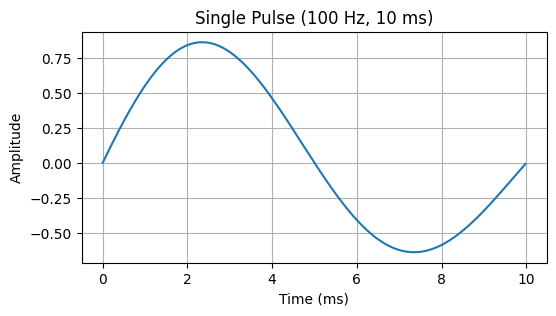

In [93]:


def pulse(sr=44100, duration=0.01, freq=100):
    t = np.linspace(0, duration, int(sr*duration), False)
    p = np.sin(2*np.pi*freq*t) * np.exp(-60*t)
    return t, p

# Generate the pulse
t, p = pulse(sr=44100, duration=0.01, freq=100)

# Plot it
plt.figure(figsize=(6,3))
plt.plot(t*1000, p)  # convert time to milliseconds
plt.title("Single Pulse (100 Hz, 10 ms)")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [94]:
sr = 44100
audio = euclidean_loop_audio(k=2, n=3, bpm=120, bars=4, sr=sr)
play_with_waveform_interface([audio], sr)


In [158]:


def volume(audio, db=0):
    """Adjust volume in dB"""
    factor = 10**(db / 20)
    return audio * factor


def lowpass(audio, sr=44100, cutoff=1000):
    b, a = butter(2, cutoff / (sr/2), btype='low')
    return lfilter(b, a, audio)

def highpass(audio, sr=44100, cutoff=500):
    b, a = butter(2, cutoff / (sr/2), btype='high')
    return lfilter(b, a, audio)


def echo(audio, sr=44100, delay=0.2, decay=0.5):
    """Add simple echo: delay in seconds, decay factor"""
    n_delay = int(sr * delay)
    output = np.copy(audio)
    for i in range(n_delay, len(audio)):
        output[i] += decay * output[i - n_delay]
    return output / np.max(np.abs(output))  # normalize to avoid clipping

def pan(audio, pan=0.0):
    """Convert mono to stereo with pan (-1 left, 1 right)"""
    left = audio * (1 - pan)/2
    right = audio * (1 + pan)/2
    return np.stack([left, right], axis=1)


def eq(audio, sr=44100, low=None, high=None):
    """Apply optional lowpass/highpass filtering"""
    if low:
        audio = lowpass(audio, sr, low)
    if high:
        audio = highpass(audio, sr, high)
    return audio

def saturate(audio, gain=2.0):
    audio = audio * gain
    audio = np.tanh(audio)  # soft clip
    return audio / np.max(np.abs(audio))

def offset(audio, sr=44100, seconds=0.0):
    """
    Shift an audio signal in time by `seconds`.
    """
    n_shift = int(seconds * sr)  # number of samples to shift
    return np.roll(audio, n_shift)

def envelope(audio, sr=44100, start=0.0, stop=None):
    """
    Apply a time-based envelope to an audio signal.
    Everything before `start` seconds and after `stop` seconds is zeroed.
    """
    out = np.copy(audio)
    n_start = int(start * sr)
    n_stop = int(stop * sr) if stop is not None else len(audio)

    out[:n_start] = 0
    out[n_stop:] = 0

    return out

def sample_envelope(audio, start=0.0, stop=1.0):
    """
    Apply an envelope to an audio signal using fractional positions of the sample array.
    Everything before `start` and after `stop` is zeroed.
    """
    n = len(audio)
    n_start = int(np.clip(start, 0.0, 1.0) * n)
    n_stop = int(np.clip(stop, 0.0, 1.0) * n)

    out = np.copy(audio)
    out[:n_start] = 0
    out[n_stop:] = 0
    return out


In [166]:
sr = 44100
bars = 4

play = []
play.append(euclidean_loop_audio(k=1, n=4, bpm=110, bars=bars, sr=sr))
#play.append(euclidean_loop_audio(k=1, n=4, bpm=110, bars=bars, sr=sr))
#play.append(euclidean_loop_audio(k=1, n=4, bpm=110, bars=bars, sr=sr))
#play.append(euclidean_loop_audio(k=1, n=4, bpm=110, bars=bars, sr=sr))
#play.append(euclidean_loop_audio(k=2, n=3, bpm=110, bars=bars, sr=sr))
#play.append(envelope(volume(euclidean_loop_audio(k=16, n=16, bpm=440*2, bars=bars*2, sr=sr), db=-10), stop=0.5))
#play.append(volume(euclidean_loop_audio(k=440, n=440, bpm=880, bars=bars, sr=sr), db=-10))
play.append(sample_envelope(volume(euclidean_loop_audio(k=16, n=16, bpm=880, bars=bars, sr=sr), db=-10), start=0.25, stop=.5))
play.append(sample_envelope(volume(euclidean_loop_audio(k=int(16*1.5), n=int(16*1.5), bpm=880*1.5, bars=bars, sr=sr), db=-10), start=0.5, stop=.75))

#play.append(offset(euclidean_loop_audio(k=16, n=16, bpm=440, bars=bars, sr=sr), seconds=1/440*0.25))
play_with_waveform_interface(play, sr)


# Task
Create an `ipytone` beat with interactive playback controls and a visual representation of the beat pattern in Jupyter.

## Initialize ipytone and prepare drum sounds

### Subtask:
Import necessary `ipytone` components and create `Sampler` instances for different drum sounds (kick, snare, hi-hat) using provided sample URLs.


**Reasoning**:
To initialize `ipytone` and prepare drum sounds as per the subtask, I need to import the required classes (`Sampler`, `Transport`, `Sequence`) and create `Sampler` instances for kick, snare, and hi-hat using the provided URLs.

